# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
<br>
Description: Visualize power bin features<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp
- FOOOF https://fooof-tools.github.io/fooof/index.html 
- PyEEG http://pyeeg.sourceforge.net/ 


## Imports

In [2]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import *

from neurodsp.plts.spectral import *

import sys


import warnings
warnings.filterwarnings('ignore')

## Data imports

In [3]:
filename_foldername_dict_path = "../data/most_currently_updated.pickle"
filename_foldername_dict = loadPickle(filename_foldername_dict_path)

foldername="P006"#filename_foldername_dict["foldername"]
filename="part_P006_exp001_block_long"#filename_foldername_dict["filename"]
print(foldername, filename)

dataframe_directory = "../data/dataframe/"+foldername+"/"
dataframe_path = dataframe_directory+filename+".pickle"

df = loadPickle(dataframe_path)

P006 part_P006_exp001_block_long


In [4]:
incorporate_matlab_data = False
if incorporate_matlab_data: 
    filtered_matlab_data_directory = "../data/filtered_matlab_data/"+foldername+"/"
    filtered_matlab_data_path = filtered_matlab_data_directory+filename+".pickle"
    filtered_matlab_data = loadPickle(filtered_matlab_data_path)
    all_data = filtered_matlab_data
    data_type="data_matlab_extended"
else :
    filtered_cleaned_data_directory = "../data/filtered_cleaned_data/"+foldername+"/"
    filtered_cleaned_data_path = filtered_cleaned_data_directory+filename+".pickle"
    filtered_cleaned_data = loadPickle(filtered_cleaned_data_path)
    all_data = filtered_cleaned_data
    data_type="data_extended"

In [5]:
## Get the person's Alpha and Theta bands
## Use that to see if the PSDs have any difference

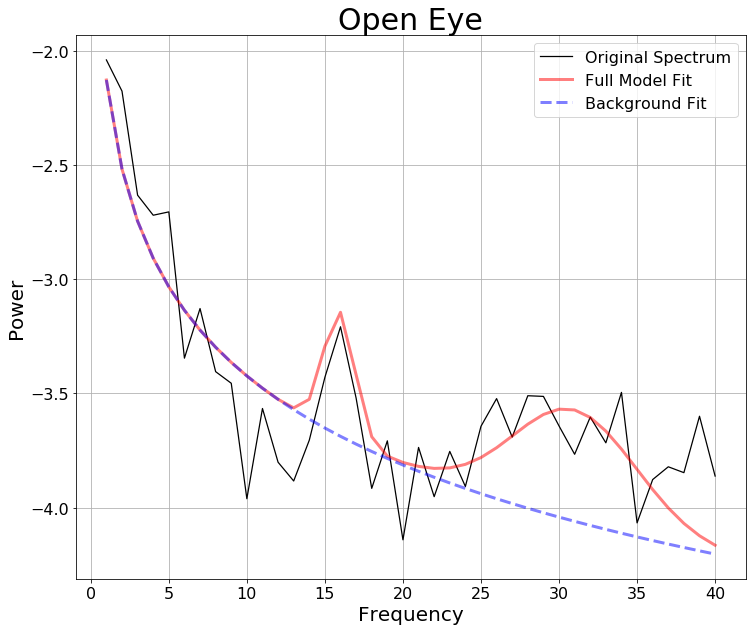

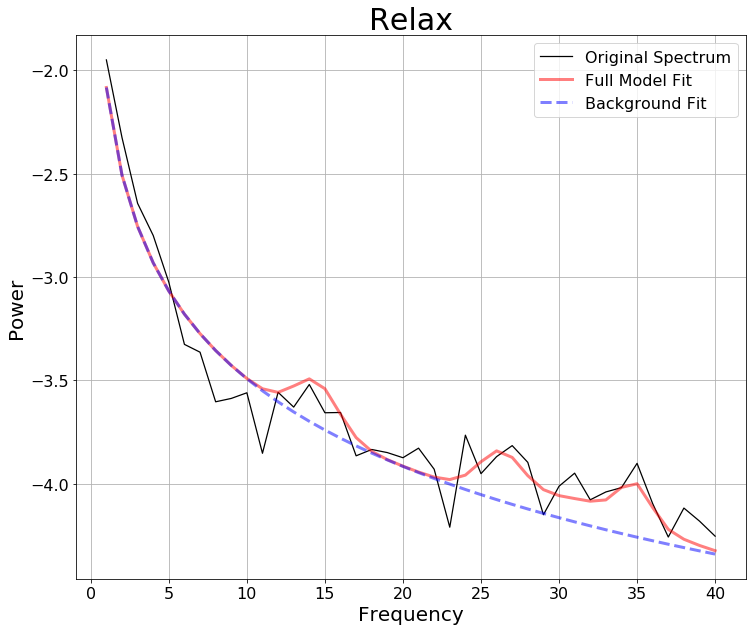

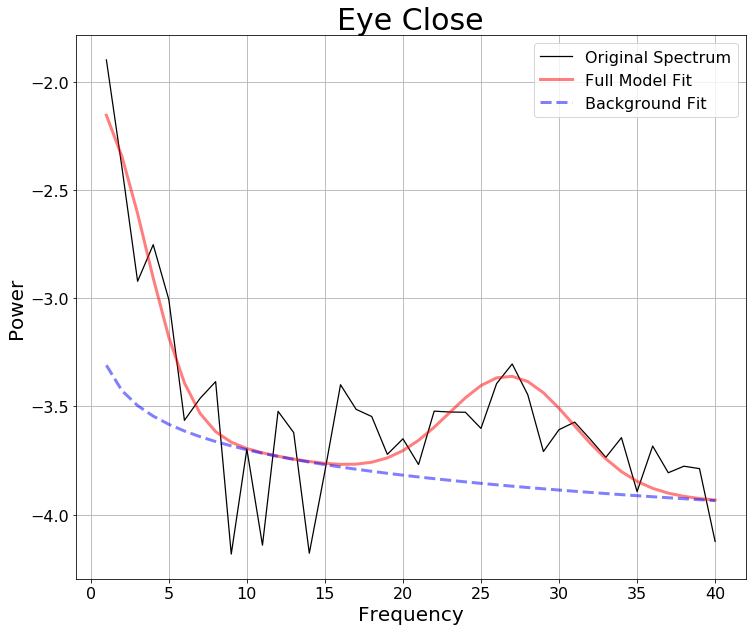

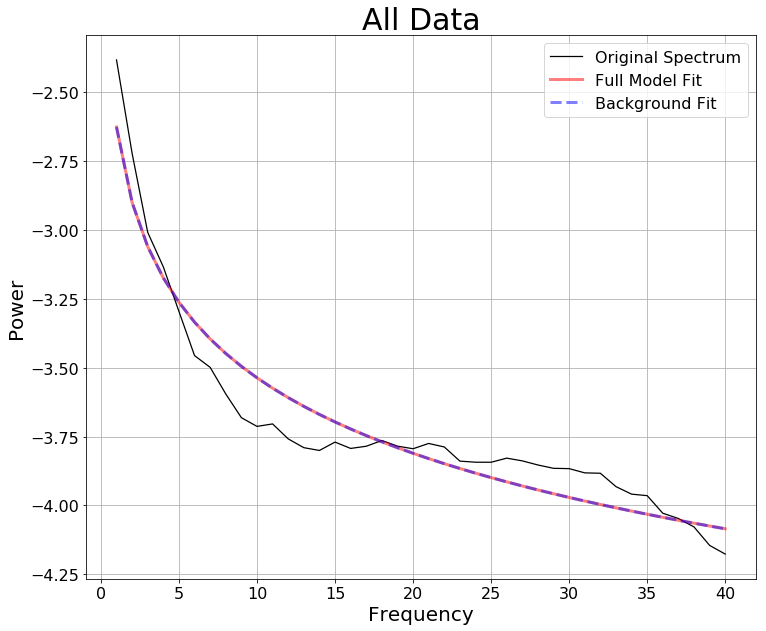

In [6]:
try:
    data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Stare there --> <-- for 5 secs\nthen Press Space', '--SpacePressed',  all_data, go_backward=True)
    data_relax, index, index_sub = getMarkerBoundSingleMarkerData('Relax for at least 5 secs\n\nthen Press Space', '--SpacePressed',  all_data, go_backward=True)
    data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes for 5 secs\n\nthen Press Space', '--SpacePressed',  all_data, go_backward=True)
    
#     data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Try not to blink and count to 5\n\nthen Press Space', '--SpacePressed',  all_data, go_backward=True)
#     data_relax, index, index_sub = getMarkerBoundSingleMarkerData('Try not to blink and count to 5\n\nthen Press Space', '--SpacePressed',  all_data, go_backward=True)
#     data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes and count to 5\n\nthen Press Space', '--SpacePressed',  all_data, go_backward=True)
    data_list = [data_open_eyes[0], data_relax[0], data_close_eyes[0], all_data]
    data_titles = ["Open Eye", "Relax", "Eye Close", "All Data"]
    eeg_list = getEEGFromDataList_AvgLeftRight(data_list)
    fits = getFOOOFFits(eeg_list, 250, (1,40))
    for i, fit in enumerate(fits) :
        fit.plot() 
        plt.title(data_titles[i], size=30)
        plt.show()
except: 
    
    # First 20 markers 
    # Useful for identifying data from calibration phase
    print("calibration markers:\n\n",filtered_cleaned_data[StreamType.MARKER.value][StreamType.DATA.value][:20])
    raise


[[29.4792239   0.60719162 11.46285714]
 [37.85816052  1.38161374  2.15706478]]


1

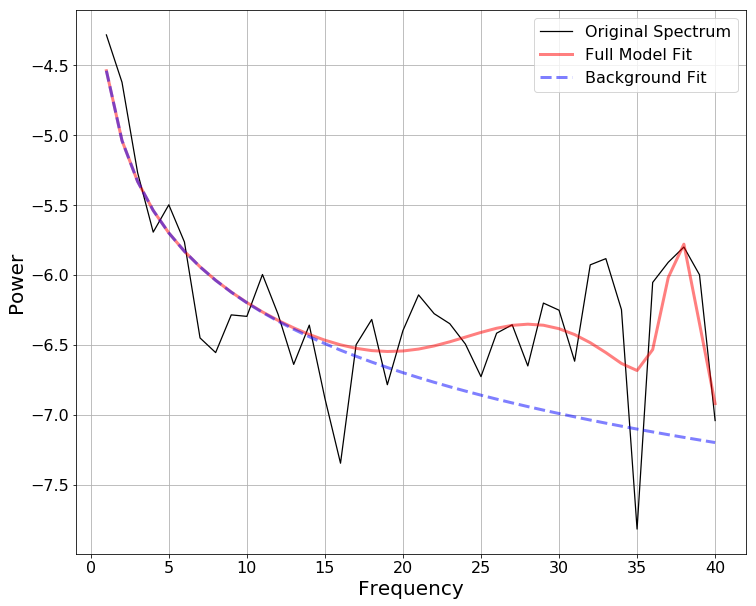

In [7]:
# Average trials, then fit FOOOF
sets = {'peak_width_limits': [0.5, 12], 'min_peak_amplitude': 0.2, 'verbose':False}

eeg_list = tidyEEGList(getEEGFromDataFrame_AvgLeftRight(df, data_type=data_type))
average_list = np.mean(eeg_list, axis=0)
fit = getFOOOFFits([average_list], 250, (1,40), sets=sets)
print(fit[0].peak_params_)

fit[0].plot()
len(fit)

In [8]:
## Get FOOOF Fits 

unfocused_state = getSmoothedPerformance((df["is_pressed"] == False) & (df["is_target"] == True), 5, 1)

#focused_state = getSmoothedPerformance(list(df["trial_time"] == 0.7), 6, 1)
unfocused_df = df[unfocused_state]
focused_df = df[np.logical_not(unfocused_state)]

# unfocused_df = df[df["trial_time"] > 0.9]
# focused_df = df[df["trial_time"] == 0.7]



focused_eeg_list = tidyEEGList(getEEGFromDataFrame_AvgLeftRight(focused_df))
focused_fits = getFOOOFFits(focused_eeg_list, 250, (1, 40), sets=sets)
focused_peak_params = [p for pp in getPeakParams(focused_fits) for p in pp]


unfocused_eeg_list = tidyEEGList(getEEGFromDataFrame_AvgLeftRight(unfocused_df))
unfocused_fits = getFOOOFFits(unfocused_eeg_list, 250, (1, 40), sets=sets)
unfocused_peak_params = [p for pp in getPeakParams(unfocused_fits) for p in pp]


print("num focus", len(focused_eeg_list))
print("num unfocus", len(unfocused_eeg_list))



num focus 289
num unfocus 96


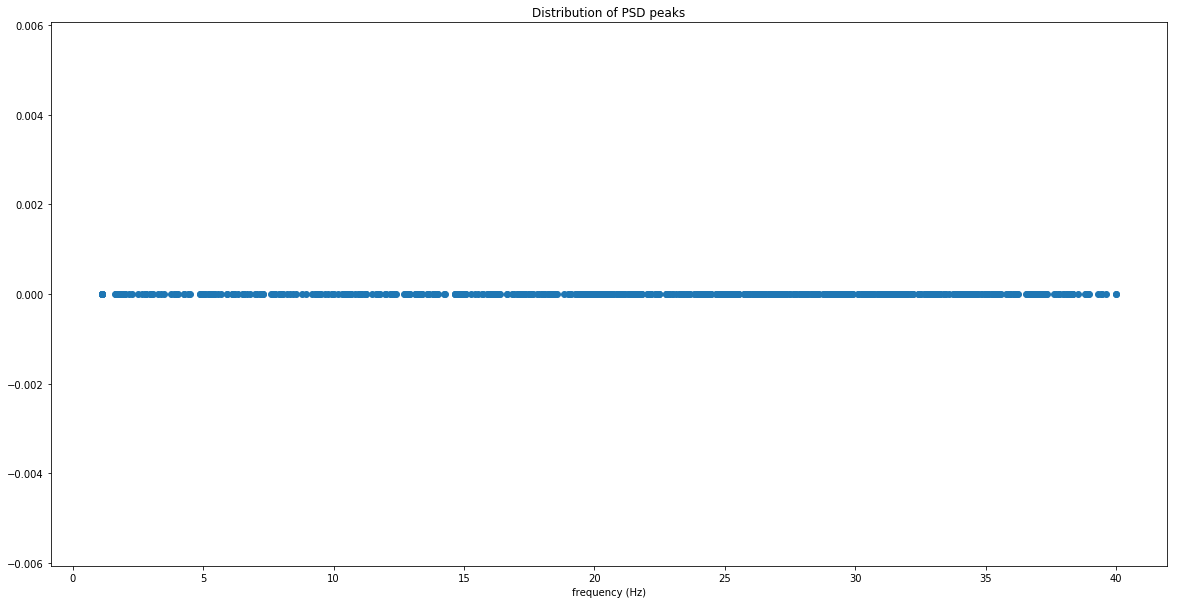

In [9]:
focus_cfs=getCFs(getPeakParams(focused_fits))
plt.figure(figsize=(20,10))
plt.title("Distribution of PSD peaks")
plt.xlabel("frequency (Hz)")
plt.scatter(focus_cfs, [0]*len(focus_cfs))
plt.show()

In [10]:
# Window and average? Average across trials? 

In [11]:
def getPeakParamsInBand(peak_params, band): 
    to_return_peak_params = list()
    trials_with_peak = list() 
    for i, peak_param in enumerate(peak_params): 
        cf = getCF(peak_param)
        if (cf > band[0]) and (cf < band[1]):
            trials_with_peak.append(i)
            to_return_peak_params.append(peak_param)
    return to_return_peak_params, trials_with_peak

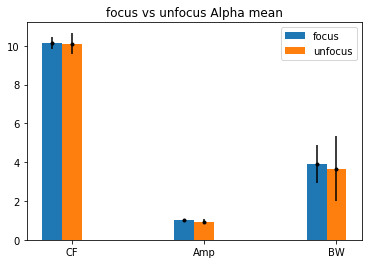

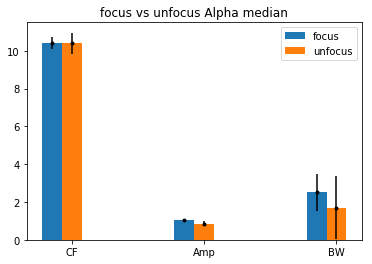

num focus with alpha 46
num unfocus with alpha 21


In [12]:
# Get Peak Params CF, Amplitude, BW  
# Alpha
wide_alpha=[8, 12]
focus_alpha_peak_params, focus_alpha_trial_indx = getPeakParamsInBand(focused_peak_params, band=wide_alpha)
focus_alpha_peak_params_mean = np.mean(focus_alpha_peak_params, axis=0)
focus_alpha_peak_params_median = np.median(focus_alpha_peak_params, axis=0)


focus_alpha_peak_params_sem = getSEM(focus_alpha_peak_params)

unfocus_alpha_peak_params, unfocus_alpha_trial_indx = getPeakParamsInBand(unfocused_peak_params, band=wide_alpha)
unfocus_alpha_peak_params_mean = np.mean(unfocus_alpha_peak_params, axis=0)
unfocus_alpha_peak_params_median = np.median(unfocus_alpha_peak_params, axis=0)

unfocus_alpha_peak_params_sem = getSEM(unfocus_alpha_peak_params)

plt.title("focus vs unfocus Alpha mean")
plotMultipleBarGraphs([focus_alpha_peak_params_mean, unfocus_alpha_peak_params_mean], 0.15, ["focus", "unfocus"], ["CF", "Amp", "BW"], error_values=[focus_alpha_peak_params_sem, unfocus_alpha_peak_params_sem])
plt.show() 
plt.title("focus vs unfocus Alpha median")
plotMultipleBarGraphs([focus_alpha_peak_params_median, unfocus_alpha_peak_params_median], 0.15, ["focus", "unfocus"], ["CF", "Amp", "BW"], error_values=[focus_alpha_peak_params_sem, unfocus_alpha_peak_params_sem])
plt.show() 
print("num focus with alpha", len(focus_alpha_trial_indx))
print("num unfocus with alpha", len(unfocus_alpha_trial_indx))



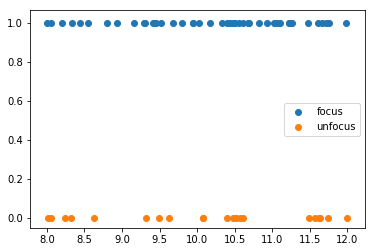

In [13]:
# Plot CF Distributions Alpha
plt.scatter(np.array(focus_alpha_peak_params)[:, 0], [1]*len(np.array(focus_alpha_peak_params)[:, 0]), label="focus")
plt.scatter(np.array(unfocus_alpha_peak_params)[:, 0], [0]*len(np.array(unfocus_alpha_peak_params)[:, 0]), label="unfocus")
plt.legend(loc='center right')
plt.show()


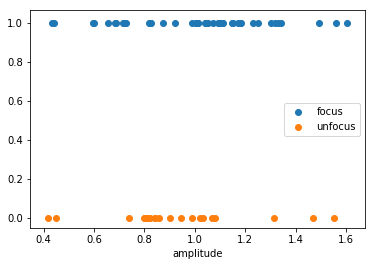

In [14]:
# Plot amp Distributions alpha
plt.scatter(np.array(focus_alpha_peak_params)[:, 1], [1]*len(np.array(focus_alpha_peak_params)[:, 1]), label="focus")
plt.scatter(np.array(unfocus_alpha_peak_params)[:, 1], [0]*len(np.array(unfocus_alpha_peak_params)[:, 1]), label="unfocus")
plt.legend(loc='center right')
plt.xlabel("amplitude")
plt.show()


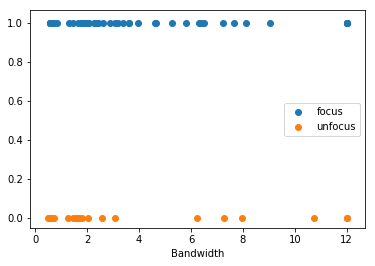

In [15]:
# Plot BW Distributions alpha
plt.scatter(np.array(focus_alpha_peak_params)[:, 2], [1]*len(np.array(focus_alpha_peak_params)[:, 2]), label="focus")
plt.scatter(np.array(unfocus_alpha_peak_params)[:, 2], [0]*len(np.array(unfocus_alpha_peak_params)[:, 2]), label="unfocus")
plt.legend(loc='center right')
plt.xlabel("Bandwidth")
plt.show()


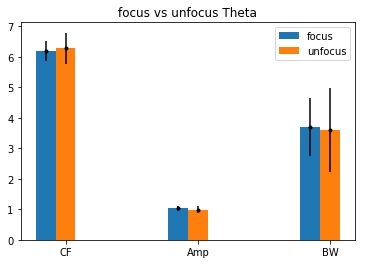

num focus with theta 48
num unfocus with theta 18


In [16]:
# Get Peak Params CF, Amplitude, BW  
# Theta
wide_theta = [4,8]
focus_theta_peak_params, focus_theta_trial_indx = getPeakParamsInBand(focused_peak_params, band=wide_theta)
focus_theta_peak_params_mean = np.mean(focus_theta_peak_params, axis=0)
focus_theta_peak_params_sem = getSEM(focus_theta_peak_params)

unfocus_theta_peak_params, unfocus_theta_trial_indx = getPeakParamsInBand(unfocused_peak_params, band=wide_theta)
unfocus_theta_peak_params_mean = np.mean(unfocus_theta_peak_params, axis=0)
unfocus_theta_peak_params_sem = getSEM(unfocus_theta_peak_params)

plt.title("focus vs unfocus Theta")
plotMultipleBarGraphs([focus_theta_peak_params_mean, unfocus_theta_peak_params_mean], 0.15, ["focus", "unfocus"], ["CF", "Amp", "BW"], error_values=[focus_theta_peak_params_sem, unfocus_theta_peak_params_sem])

print("num focus with theta", len(focus_theta_trial_indx))
print("num unfocus with theta", len(unfocus_theta_trial_indx))



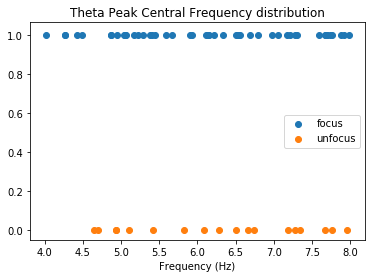

In [17]:
# Plot CF Distributions Theta
plt.scatter(np.array(focus_theta_peak_params)[:, 0], [1]*len(np.array(focus_theta_peak_params)[:, 0]), label="focus")
plt.scatter(np.array(unfocus_theta_peak_params)[:, 0], [0]*len(np.array(unfocus_theta_peak_params)[:, 0]), label="unfocus")
plt.legend()
plt.title("Theta Peak Central Frequency distribution")
plt.xlabel("Frequency (Hz)")
plt.show()


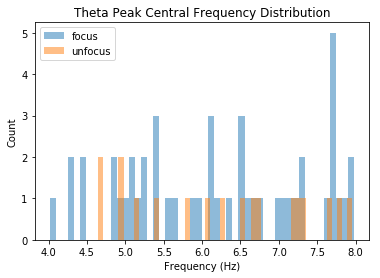

In [18]:
plt.hist(np.array(focus_theta_peak_params)[:, 0], bins=50, alpha=0.5, label="focus");
plt.hist(np.array(unfocus_theta_peak_params)[:, 0], bins=50, alpha=0.5, label="unfocus");
plt.legend()
plt.title("Theta Peak Central Frequency Distribution")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.show()

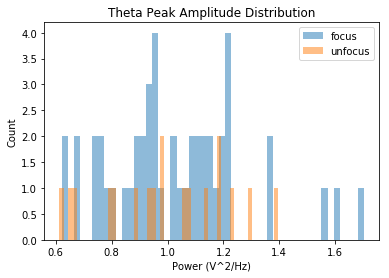

In [19]:
plt.hist(np.array(focus_theta_peak_params)[:, 1], bins=50, alpha=0.5, label="focus");
plt.hist(np.array(unfocus_theta_peak_params)[:, 1], bins=50, alpha=0.5, label="unfocus");
plt.legend()
plt.title("Theta Peak Amplitude Distribution")
plt.xlabel("Power (V^2/Hz)")
plt.ylabel("Count")
plt.show()

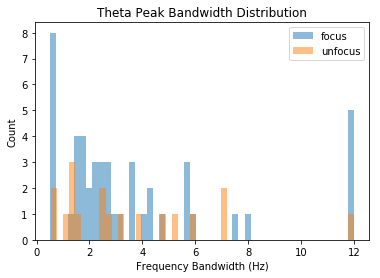

In [20]:
plt.hist(np.array(focus_theta_peak_params)[:, 2], bins=50, alpha=0.5, label="focus");
plt.hist(np.array(unfocus_theta_peak_params)[:, 2], bins=50, alpha=0.5, label="unfocus");
plt.legend()
plt.title("Theta Peak Bandwidth Distribution")
plt.xlabel("Frequency Bandwidth (Hz)")
plt.ylabel("Count")
plt.show()

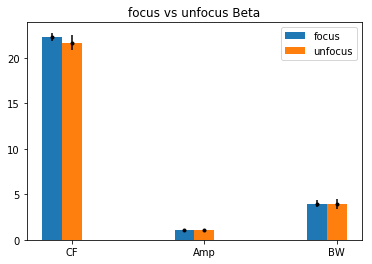

num focus with Beta 422
num unfocus with Beta 145


In [21]:
# Get Peak Params CF, Amplitude, BW  
# Beta
wide_beta = [12,30]
focus_beta_peak_params, focus_beta_trial_indx = getPeakParamsInBand(focused_peak_params, band=wide_beta)
focus_beta_peak_params_mean = np.mean(focus_beta_peak_params, axis=0)
focus_beta_peak_params_sem = getSEM(focus_beta_peak_params)

unfocus_beta_peak_params, unfocus_beta_trial_indx = getPeakParamsInBand(unfocused_peak_params, band=wide_beta)
unfocus_beta_peak_params_mean = np.mean(unfocus_beta_peak_params, axis=0)
unfocus_beta_peak_params_sem = getSEM(unfocus_beta_peak_params)

plt.title("focus vs unfocus Beta")
plotMultipleBarGraphs([focus_beta_peak_params_mean, unfocus_beta_peak_params_mean], 0.15, ["focus", "unfocus"], ["CF", "Amp", "BW"], error_values=[focus_beta_peak_params_sem, unfocus_beta_peak_params_sem])

print("num focus with Beta", len(focus_beta_trial_indx))
print("num unfocus with Beta", len(unfocus_beta_trial_indx))



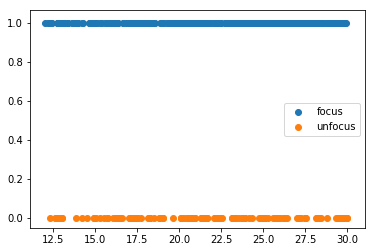

In [22]:
# Plot CF Distributions beta
plt.scatter(np.array(focus_beta_peak_params)[:, 0], [1]*len(np.array(focus_beta_peak_params)[:, 0]), label="focus")
plt.scatter(np.array(unfocus_beta_peak_params)[:, 0], [0]*len(np.array(unfocus_beta_peak_params)[:, 0]), label="unfocus")
plt.legend()
plt.show()


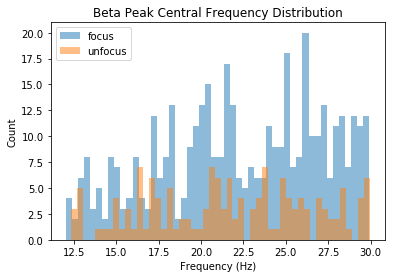

In [25]:
plt.hist(np.array(focus_beta_peak_params)[:, 0], bins=50, alpha=0.5, label="focus");
plt.hist(np.array(unfocus_beta_peak_params)[:, 0], bins=50, alpha=0.5, label="unfocus");
plt.legend()
plt.title("Beta Peak Central Frequency Distribution")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.show()

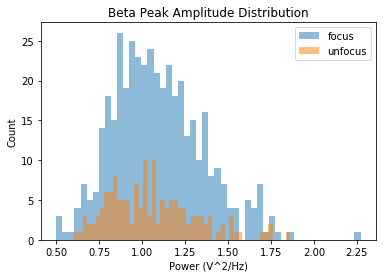

In [24]:
plt.hist(np.array(focus_beta_peak_params)[:, 1], bins=50, alpha=0.5, label="focus");
plt.hist(np.array(unfocus_beta_peak_params)[:, 1], bins=50, alpha=0.5, label="unfocus");
plt.legend()
plt.title("Beta Peak Amplitude Distribution")
plt.xlabel("Power (V^2/Hz)")
plt.ylabel("Count")
plt.show()

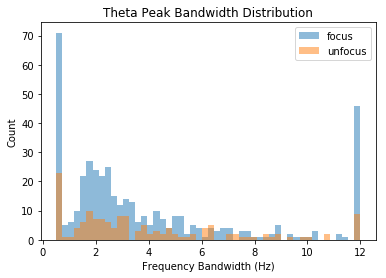

In [23]:
plt.hist(np.array(focus_beta_peak_params)[:, 2], bins=50, alpha=0.5, label="focus");
plt.hist(np.array(unfocus_beta_peak_params)[:, 2], bins=50, alpha=0.5, label="unfocus");
plt.legend()
plt.title("Beta Peak Bandwidth Distribution")
plt.xlabel("Frequency Bandwidth (Hz)")
plt.ylabel("Count")
plt.show()